In [34]:
#cu101 
!pip install torch-geometric \
  torch-sparse==latest+cu101 \
  torch-scatter==latest+cu101 \
  torch-cluster==latest+cu101 \
  -f https://pytorch-geometric.com/whl/torch-1.4.0.html

Looking in links: https://pytorch-geometric.com/whl/torch-1.4.0.html
  Using cached https://pytorch-geometric.com/whl/torch-1.4.0/torch_sparse-latest%2Bcu101-cp36-cp36m-linux_x86_64.whl
  Using cached https://pytorch-geometric.com/whl/torch-1.4.0/torch_scatter-latest%2Bcu101-cp36-cp36m-linux_x86_64.whl
  Using cached https://pytorch-geometric.com/whl/torch-1.4.0/torch_cluster-latest%2Bcu101-cp36-cp36m-linux_x86_64.whl
  Found existing installation: torch-sparse 0.6.1
    Uninstalling torch-sparse-0.6.1:
      Successfully uninstalled torch-sparse-0.6.1
  Found existing installation: torch-scatter 2.0.4
    Uninstalling torch-scatter-2.0.4:
      Successfully uninstalled torch-scatter-2.0.4
  Found existing installation: torch-cluster 1.5.4
    Uninstalling torch-cluster-1.5.4:
      Successfully uninstalled torch-cluster-1.5.4


<class 'networkx.classes.digraph.DiGraph'>


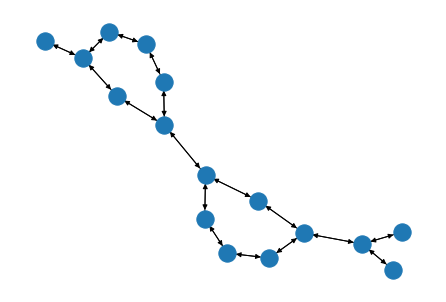

In [35]:
import torch
import networkx as nx 
from matplotlib import pyplot as plt 
#from torch_geometric.datasets import Entities 
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.utils import convert
a=TUDataset(root=".", name="MUTAG").shuffle()
a=convert.to_networkx(a[0])
print(type(a))
nx.draw(a)
plt. show()

 

In [0]:
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        # data = data.to(torch.device('cuda'))
        out = model(data.pos, data.batch)
        loss = F.nll_loss(F.log_softmax(out, dim=1), data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

for epoch in range(1, 10):
    loss = train()
    print('Epoch: {:01d}, Loss: {:.4f}'.format(epoch, loss))

In [0]:

dataset = TUDataset('.', name='MUTAG').shuffle()
test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[-4:]
test_loader = DataLoader(test_dataset, batch_size=1)
train_loader = DataLoader(train_dataset, batch_size=4)

In [33]:
for data in train_loader:
  print(data.batch)
print(dataset.num_features)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3])
7


In [54]:
import os.path as osp

import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
from torch_geometric.nn import GINConv, global_add_pool, GCNConv, global_mean_pool

#path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'MUTAG')
dataset = TUDataset('.', name='MUTAG').shuffle()
test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]
test_loader = DataLoader(test_dataset, batch_size=128)
train_loader = DataLoader(train_dataset, batch_size=128)

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        num_features = dataset.num_features
        dim = 32
        hidden=dim
        num_layers=4
        self.conv1 = GCNConv(dataset.num_features, hidden)
        self.bn1 = torch.nn.BatchNorm1d(hidden)                  
        self.convs = torch.nn.ModuleList()
        self.bn=torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(GCNConv(hidden, hidden))
            self.bn.append( torch.nn.BatchNorm1d(hidden) )
        self.lin1 = Linear(hidden, hidden)
        self.lin2 = Linear(hidden, dataset.num_classes)
        self.bn1 = torch.nn.BatchNorm1d(dim)                  #######################################################


    def forward(self, x, edge_index, batch):
        #x, edge_index, batch = data.x, data.edge_index, data.batch          #############################################3
        x = F.relu(self.conv1(x, edge_index))
        x=self.bn1(x)
        for i,conv in enumerate(self.convs):
            x = F.relu(conv(x, edge_index))
            x=self.bn[i](x)
        x = global_mean_pool(x, batch)
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.1, training=self.training)     #######################################################################3
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)




device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


def train(epoch):
    model.train()

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.1 * param_group['lr']

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_dataset)


def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)


for epoch in range(1, 200):
    train_loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print('Epoch: {:03d}, Train Loss: {:.7f}, '
          'Train Acc: {:.7f}, Test Acc: {:.7f}'.format(epoch, train_loss,
                                                       train_acc, test_acc))

Epoch: 001, Train Loss: 0.6967918, Train Acc: 0.6941176, Test Acc: 0.6111111
Epoch: 002, Train Loss: 0.5780008, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 003, Train Loss: 0.4958300, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 004, Train Loss: 0.4840325, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 005, Train Loss: 0.4748246, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 006, Train Loss: 0.4502562, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 007, Train Loss: 0.4496816, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 008, Train Loss: 0.4384950, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 009, Train Loss: 0.4018524, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 010, Train Loss: 0.3768635, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 011, Train Loss: 0.3604881, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 012, Train Loss: 0.3766768, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 013, Train Loss: 0.4095104, Train Acc: 0.5235294, Test Acc: 0.5555556